In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import requests
from datetime import timedelta
import os
import re
import matplotlib as mpl

%config InlineBackend.figure_format = 'png'

# Covid-19 in Nederland

Dit notebook toont het aantal Covid-19 besmettingen in Nederland, en fit hier een exponentiële en logistische functie aan.

Let op: 
- Deze grafiek is niet door een expert gemaakt, deze informatie is niet beter dan de informatie waar het RIVM over beschikt.
- Het verspreidingspatroon van een virus volgt alleen in de beginstadia een exponentiële functie.
- Effecten van meer/betere tests, betere voorlichting, etc. hebben invloed op de verspreiding, deze worden _niet_ meegenomen.
- Het RIVM test gezinsleden van besmette mensen (meestal) niet. Mogelijk deden ze dat eerder wel.
- 3.9% van de ziekenhuismedewerkers in Brabant is besmet ([blijkt uit steekproef](https://www.rivm.nl/nieuws/resultaat-steekproef-4-ziekenhuismedewerkers-heeft-coronavirus)). In het Radboud alleen al werken 11k mensen.

Nuancering:

<img src="https://imgs.xkcd.com/comics/extrapolating.png" alt="curve-fit" width="300"/>

(bron: [xkcd 605](https://xkcd.com/605/))

## Useful links

- Epidemic calculator: http://gabgoh.github.io/COVID/index.html
- Epidemic calculator with different scenario's: https://neherlab.org/covid19/
- Worldwide numberes on Corona: https://www.worldometers.info/coronavirus/
- Overview on open source Corona-related projects: https://github.com/soroushchehresa/awesome-coronavirus

## Opinions and background articles
- [Coronavirus: The Hammer and The Dance](https://medium.com/@tomaspueyo/coronavirus-the-hammer-and-the-dance-be9337092b56)
- [Coronavirus in Deutschland - Alle bestätigten Fälle auf einer Karte (German)](https://www.zeit.de/wissen/gesundheit/2020-03/coronavirus-deutschland-infektionen-faelle-verbreitung-epidemie-karte)

## Datasets

### Netherlands

Data sources:
- [RIVM](https://www.rivm.nl/nieuws/actuele-informatie-over-coronavirus) - updated daily at 14:00
- [Nationale Intensive Care Evaluatie](https://stichting-nice.nl) - updated dynamically

In [2]:
def get_nl_data():
    df_nl = pd.read_csv("data/nl.csv", index_col=0)
    df_nl.index = pd.to_datetime(df_nl.index)

    # Get current IC cases
    df_icu = pd.read_json("https://stichting-nice.nl/covid-19/public/intake-count/")
    df_icu.date = pd.to_datetime(df_icu.date)
    df_icu.set_index("date", inplace=True)
    df_icu.index = df_icu.index + timedelta(hours=14)
    df_nl["current_icu"] = df_icu["intakeCount"]

    # Get cumulative IC cases
    df_icu = pd.read_json(
        "https://stichting-nice.nl/covid-19/public/intake-cumulative/"
    )
    df_icu.date = pd.to_datetime(df_icu.date)
    df_icu.set_index("date", inplace=True)
    df_icu.index = df_icu.index + timedelta(hours=14)
    df_nl["hospitalized_icu"] = df_icu["intakeCumulative"]

    # Calculate cumulative non-IC cases (not directly available)
    df_nl["hospitalized_without_icu"] = (
        df_nl["hospitalized_cases"] - df_nl["hospitalized_icu"]
    )

    # Calculate new cases
    df_nl["new_cases"] = df_nl["cumulative_cases"].diff().fillna(0)
    df_nl["new_deaths"] = df_nl["deaths"].diff().fillna(0)

    return df_nl

In [3]:
df_netherlands = get_nl_data()
print(
    f"{df_netherlands.shape[0]} days, from {df_netherlands.index.min()} to {df_netherlands.index.max()}"
)
df_netherlands.tail(1)

42 days, from 2020-02-27 14:00:00 to 2020-04-08 14:00:00


cumulative_cases  deaths  hospitalized_cases  \
2020-04-08 14:00:00             20549  2248.0              7735.0   

                     current_icu  hospitalized_icu  hospitalized_without_icu  \
2020-04-08 14:00:00       1192.0            2046.0                    5689.0   

                     new_cases  new_deaths  
2020-04-08 14:00:00      969.0       147.0

### Italy

Data sources:
- [Italian government](http://www.salute.gov.it/portale/news/p3_2_0.jsp?lingua=italiano&id=1285) - updated daily at 18:00
- [csv version](https://github.com/pcm-dpc/COVID-19) in `pcm-dpc/COVID-19` github repository.



In [4]:
def load_italy():
    df_italy = pd.concat(
        [
            pd.read_csv(
                "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
            ),
            pd.read_csv(
                "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale-latest.csv"
            ),
        ]
    ).drop_duplicates()

    df_italy.rename(
        columns={
            "data": "date",
            "stato": "country",
            "ricoverati_con_sintomi": "hospitalized_without_icu",
            "terapia_intensiva": "hospitalized_icu",
            "totale_ospedalizzati": "hospitalized_cases",
            "isolamento_domiciliare": "patients_quarantined",
            "totale_attualmente_positivi": "current_cases",
            "nuovi_attualmente_positivi": "new_cases",
            "dimessi_guariti": "recovered",
            "deceduti": "deaths",
            "totale_casi": "cumulative_cases",
            "tamponi": "performed_tests",
        },
        inplace=True,
    )
    del df_italy["country"]
    df_italy["current_icu"] = df_italy["hospitalized_icu"]
    df_italy["current_non_icu"] = df_italy["hospitalized_without_icu"]
    df_italy["new_deaths"] = df_italy["deaths"].diff().fillna(0)
    df_italy["new_cases"] = df_italy["cumulative_cases"].diff().fillna(0)

    df_italy.date = pd.to_datetime(df_italy.date)
    df_italy.set_index("date", inplace=True)
    return df_italy

In [5]:
df_italy = load_italy()
print(
    f"{df_italy.shape[0]} days, from {df_italy.index.min()} to {df_italy.index.max()}"
)
df_italy.tail(1)

44 days, from 2020-02-24 18:00:00 to 2020-04-07 17:00:00


hospitalized_without_icu  hospitalized_icu  \
date                                                              
2020-04-07 17:00:00                     28718              3792   

                     hospitalized_cases  patients_quarantined  \
date                                                            
2020-04-07 17:00:00               32510                 61557   

                     totale_positivi  variazione_totale_positivi  \
date                                                               
2020-04-07 17:00:00            94067                         880   

                     nuovi_positivi  recovered  deaths  cumulative_cases  \
date                                                                       
2020-04-07 17:00:00            3039      24392   17127            135586   

                     performed_tests note_it note_en  current_icu  \
date                                                                
2020-04-07 17:00:00           755445     NaN     NaN         3792   

                     current_non_icu  new_deaths  new_cases  
date                                                         
2020-04-07 17:00:00            28718       604.0     3039.0

## Event timeline

In [6]:
events = pd.DataFrame(
    columns=["country", "start_date", "end_date", "description", "url"],
    data=[
        [
            "NL",
            "2020-03-09",
            None,
            "Geen handenschudden",
            "https://www.rijksoverheid.nl/onderwerpen/coronavirus-covid-19/nieuws/2020/03/09/hygienemaatregelen-van-belang-om-verspreiding-coronavirus-tegen-te-gaan",
        ],
        [
            "NL",
            "2020-03-12",
            None,
            "Thuiswerken, evenementen > 100 verboden, thuisblijven bij klachten",
            "https://www.rijksoverheid.nl/onderwerpen/coronavirus-covid-19/nieuws/2020/03/12/nieuwe-maatregelen-tegen-verspreiding-coronavirus-in-nederland",
        ],
        [
            "NL",
            "2020-03-15",
            None,
            "Scholen, horeca en sport dicht, 1.5 meter afstand",
            "https://www.rijksoverheid.nl/onderwerpen/coronavirus-covid-19/nieuws/2020/03/15/aanvullende-maatregelen-onderwijs-horeca-sport",
        ],
        [
            "NL",
            "2020-03-18",
            "2020-04-18",
            "Grenzen vanaf buten Europa dicht",
            "https://www.rijksoverheid.nl/onderwerpen/coronavirus-covid-19/nieuws/2020/03/18/nederland-sluit-de-grenzen-voor-mensen-van-buiten-europa",
        ],
        [
            "NL",
            "2020-03-19",
            None,
            "Verpleeghuizen dicht voor bezoek",
            "https://www.rijksoverheid.nl/onderwerpen/coronavirus-covid-19/nieuws/2020/03/19/bezoek-aan-verpleeghuizen-niet-langer-mogelijk-vanwege-corona",
        ],
        [
            "NL",
            "2020-03-23",
            "2020-06-01",
            "Evenementenverbod, boetes",
            "https://www.rijksoverheid.nl/onderwerpen/coronavirus-covid-19/nieuws/2020/03/23/aangescherpte-maatregelen-om-het-coronavirus-onder-controle-te-krijgen",
        ],
    ],
)
events

country  start_date    end_date  \
0      NL  2020-03-09        None   
1      NL  2020-03-12        None   
2      NL  2020-03-15        None   
3      NL  2020-03-18  2020-04-18   
4      NL  2020-03-19        None   
5      NL  2020-03-23  2020-06-01   

                                         description  \
0                                Geen handenschudden   
1  Thuiswerken, evenementen > 100 verboden, thuis...   
2  Scholen, horeca en sport dicht, 1.5 meter afstand   
3                   Grenzen vanaf buten Europa dicht   
4                   Verpleeghuizen dicht voor bezoek   
5                          Evenementenverbod, boetes   

                                                 url  
0  https://www.rijksoverheid.nl/onderwerpen/coron...  
1  https://www.rijksoverheid.nl/onderwerpen/coron...  
2  https://www.rijksoverheid.nl/onderwerpen/coron...  
3  https://www.rijksoverheid.nl/onderwerpen/coron...  
4  https://www.rijksoverheid.nl/onderwerpen/coron...  
5  https://www.rijksoverheid.nl/onderwerpen/coron...

## Visualization

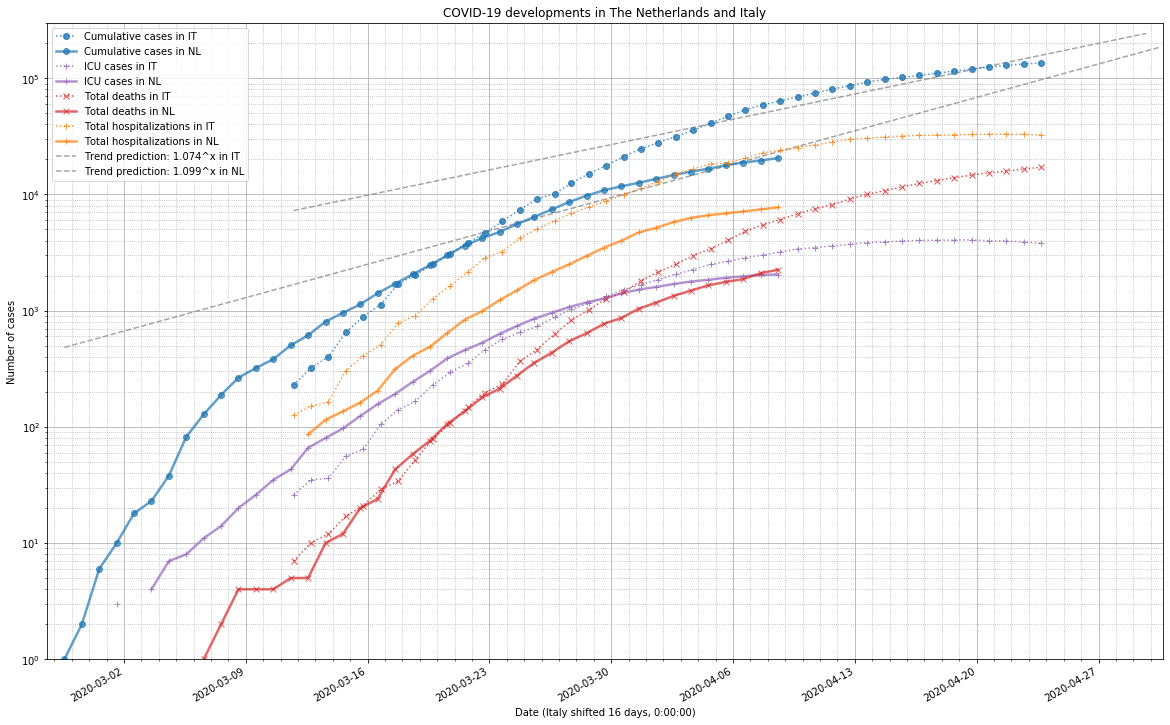

In [7]:
def fit_prediction(df, max_date, kind="exponential", offset=None):
    def exp_func(x, a, b):
        return b ** (x - a)

    def logistic_func(x, L, k, x0):
        return L / (1 + np.exp(-k * (x - x0)))

    if offset:
        df = df.copy()
        df.index = df.index + offset

    [a, b], _ = curve_fit(
        exp_func, np.arange(len(df.cumulative_cases[:])), df.cumulative_cases[:]
    )
    [L, k, x0], _ = curve_fit(
        logistic_func,
        np.arange(len(df.cumulative_cases)),
        df.cumulative_cases,
        p0=[1e4, 0.3, 30],
    )
    [k_, x0_], _ = curve_fit(
        lambda x, k_, x0_: logistic_func(x, 17.4e6, k_, x0_),
        np.arange(len(df.cumulative_cases)),
        df.cumulative_cases,
        p0=[0.3, 30],
    )

    date_index = pd.date_range(start=df.index.min(), end=max_date, freq="D",)
    y_pred_exp = exp_func(np.arange(len(date_index)), a, b)
    y_pred_logistic = logistic_func(np.arange(len(date_index)), L, k, x0)

    label = ""
    if kind == "exponential":
        curve = pd.Series(index=date_index, data=y_pred_exp)
        label = f"prediction: {b.round(3)}^x"
    elif kind == "logistic":
        curve = pd.Series(index=date_index, data=y_pred_logistic)
        label = f"Prediction: logistic function (conv. -> {L.round(1)})"
    else:
        raise Error(f"Unknown kind: {kind}")

    return curve, label


def plot_prediction(ax, series, **kwargs):
    series.plot(ax=ax, c="C7", alpha=0.7, lw=1.5, style="--", **kwargs)


def plot_situation(ax, df, offset=None, country="", **kwargs):
    if offset:
        df = df.copy()
        df.index = df.index + offset

    kwargs = {"alpha": 0.8, **kwargs}

    df.cumulative_cases.plot(
        label=f"Cumulative cases in {country}", marker="o", c="C0", ax=ax, **kwargs
    )
    df.hospitalized_cases.plot(
        label=f"Total hospitalizations in {country}",
        marker="+",
        c="C1",
        ax=ax,
        **kwargs,
    )
    df.hospitalized_icu.plot(
        label=f"ICU cases in {country}", marker="+", c="C4", ax=ax, **kwargs
    )
    df.deaths.plot(
        label=f"Total deaths in {country}", marker="x", c="C3", ax=ax, **kwargs
    )


fig, ax = plt.subplots(figsize=(20, 13))

offset_italy = timedelta(days=16)
min_date = np.min(
    [df_netherlands.index.min(), df_italy.index.min() + offset_italy]
) - timedelta(days=1)
max_date = np.max(
    [df_netherlands.index.max(), df_italy.index.max() + offset_italy]
) + timedelta(days=7)

# Netherlands
curve, label = fit_prediction(df_netherlands, max_date=max_date)
plot_prediction(ax, curve, label=f"Trend {label} in NL")
plot_situation(ax, df_netherlands, country="NL", lw=2.5, alpha=0.7)

# Italy
curve, label = fit_prediction(df_italy, max_date=max_date, offset=offset_italy)
plot_prediction(ax, curve, label=f"Trend {label} in IT")
plot_situation(ax, df_italy, offset=offset_italy, country="IT", style=":")

ax.set_yscale("log")
ax.set_ylim([1, 3e5])
ax.set_xlim(min_date, max_date)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(0))
ax.xaxis.set_minor_locator(mdates.DayLocator())

ax.grid(which="minor", linestyle=(":"))
ax.grid(which="major")
ax.set_xlabel(f"Date (Italy shifted {offset_italy})")
ax.set_ylabel("Number of cases")
ax.set_title("COVID-19 developments in The Netherlands and Italy")
fig.autofmt_xdate()

# ax.legend()
ax.legend(
    *zip(
        *sorted(
            zip(*ax.get_legend_handles_labels()),
            key=lambda s: [
                int(t) if t.isdigit() else t.lower() for t in re.split("(\d+)", s[1])
            ],
        )
    )
)

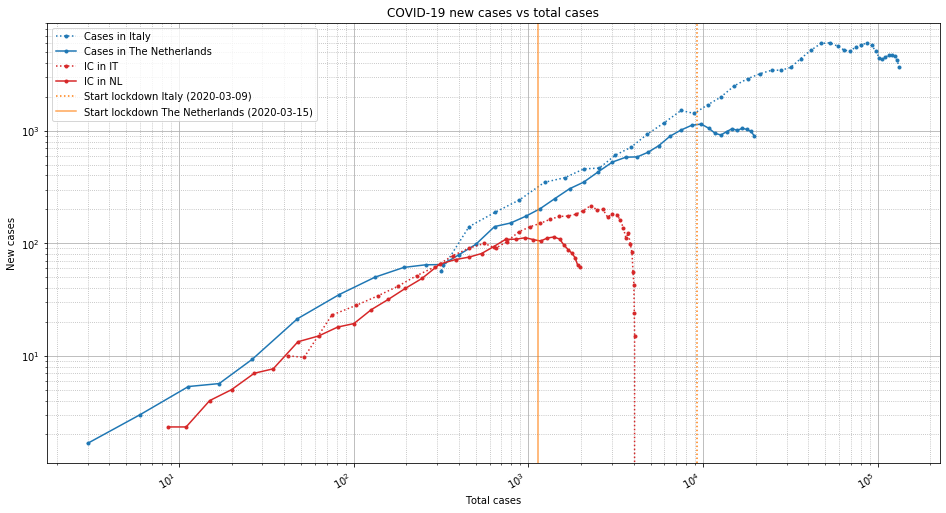

In [8]:
fig, ax = plt.subplots(figsize=(16, 9))

smoothing = 3

# Netherlands cases
df_netherlands.rolling(smoothing, center=True).mean().plot(
    x="cumulative_cases",
    y="new_cases",
    ax=ax,
    label="Cases in The Netherlands",
    c="C0",
    marker=".",
)

# Italy cases
df_italy.rolling(smoothing, center=True).mean().plot(
    x="cumulative_cases",
    y="new_cases",
    marker=".",
    style=":",
    color="C0",
    ax=ax,
    label="Cases in Italy",
)

ax.axvline(
    df_italy["2020-03-09":"2020-03-09"].iloc[0]["cumulative_cases"],
    c="C1",
    label="Start lockdown Italy (2020-03-09)",
    linestyle="dotted",
    alpha=1,
)

# NL IC cases
ax.plot(
    df_netherlands["hospitalized_icu"].rolling(smoothing, center=True).mean()[:-2],
    df_netherlands["hospitalized_icu"]
    .rolling(smoothing, center=True)
    .mean()
    .diff()[:-2],
    label="IC in NL",
    c="C3",
    marker=".",
)

ax.axvline(
    df_netherlands["2020-03-15":"2020-03-15"].iloc[0]["cumulative_cases"],
    c="C1",
    label="Start lockdown The Netherlands (2020-03-15)",
    alpha=0.7,
)

# IT IC Cases
ax.plot(
    df_italy["hospitalized_icu"].rolling(smoothing, center=True).mean()[:-2],
    df_italy["hospitalized_icu"].rolling(smoothing, center=True).mean().diff()[:-2],
    label="IC in IT",
    linestyle="dotted",
    c="C3",
    marker=".",
)


ax.set_yscale("log")
ax.set_xscale("log")

ax.grid(which="minor", linestyle=(":"))
ax.grid(which="major")
ax.set_xlabel(f"Total cases")
ax.set_ylabel("New cases")
ax.set_title("COVID-19 new cases vs total cases")
fig.autofmt_xdate()

# ax.legend()
ax.legend(
    *zip(
        *sorted(
            zip(*ax.get_legend_handles_labels()),
            key=lambda s: [
                int(t) if t.isdigit() else t.lower() for t in re.split("(\d+)", s[1])
            ],
        )
    )
)

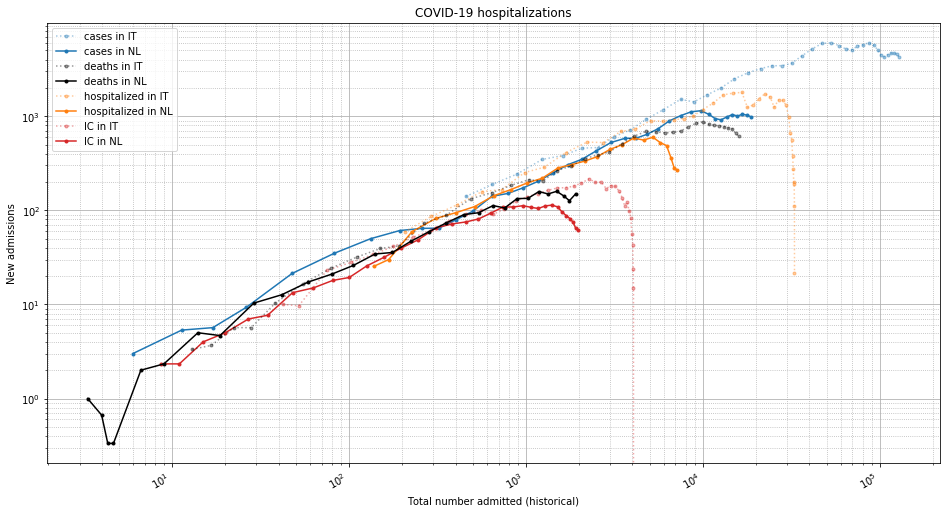

In [10]:
fig, ax = plt.subplots(figsize=(16, 9))

it_alpha = 0.4

smoothing = 3

# NL cases
ax.plot(
    df_netherlands["cumulative_cases"].rolling(smoothing, center=True).mean()[:-2],
    df_netherlands["cumulative_cases"]
    .rolling(smoothing, center=True)
    .mean()
    .diff()[:-2],
    label="cases in NL",
    c="C0",
    marker=".",
)

# IT Cases
ax.plot(
    df_italy["cumulative_cases"].rolling(smoothing, center=True).mean()[:-2],
    df_italy["cumulative_cases"].rolling(smoothing, center=True).mean().diff()[:-2],
    label="cases in IT",
    linestyle="dotted",
    c="C0",
    marker=".",
    alpha=it_alpha,
)

# NL IC cases
ax.plot(
    df_netherlands["hospitalized_icu"].rolling(smoothing, center=True).mean()[:-2],
    df_netherlands["hospitalized_icu"]
    .rolling(smoothing, center=True)
    .mean()
    .diff()[:-2],
    label="IC in NL",
    c="C3",
    marker=".",
)

# IT IC Cases
ax.plot(
    df_italy["hospitalized_icu"].rolling(smoothing, center=True).mean()[:-4],
    df_italy["hospitalized_icu"].rolling(smoothing, center=True).mean().diff()[:-4],
    label="IC in IT",
    linestyle="dotted",
    c="C3",
    marker=".",
    alpha=it_alpha,
)

# NL hospital cases
ax.plot(
    df_netherlands["hospitalized_cases"].rolling(smoothing, center=True).mean()[:-2],
    df_netherlands["hospitalized_cases"]
    .rolling(smoothing, center=True)
    .mean()
    .diff()[:-2],
    label="hospitalized in NL",
    c="C1",
    marker=".",
)

# IT hospital Cases
ax.plot(
    df_italy["hospitalized_cases"].rolling(smoothing, center=True).mean()[:-2],
    df_italy["hospitalized_cases"].rolling(smoothing, center=True).mean().diff()[:-2],
    label="hospitalized in IT",
    linestyle="dotted",
    c="C1",
    marker=".",
    alpha=it_alpha,
)

# NL deaths
ax.plot(
    df_netherlands["deaths"].rolling(smoothing, center=True).mean()[:-2],
    df_netherlands["deaths"].rolling(smoothing, center=True).mean().diff()[:-2],
    label="deaths in NL",
    c="k",
    marker=".",
)

# IT deaths
ax.plot(
    df_italy["deaths"].rolling(smoothing, center=True).mean()[:-2],
    df_italy["deaths"].rolling(smoothing, center=True).mean().diff()[:-2],
    label="deaths in IT",
    linestyle="dotted",
    c="k",
    marker=".",
    alpha=it_alpha,
)


ax.set_yscale("log")
ax.set_xscale("log")

ax.grid(which="minor", linestyle=(":"))
ax.grid(which="major")
ax.set_xlabel(f"Total number admitted (historical)")
ax.set_ylabel("New admissions")
ax.set_title("COVID-19 hospitalizations")
fig.autofmt_xdate()

# ax.legend()
ax.legend(
    *zip(
        *sorted(
            zip(*ax.get_legend_handles_labels()),
            key=lambda s: [
                int(t) if t.isdigit() else t.lower() for t in re.split("(\d+)", s[1])
            ],
        )
    )
)

### ICU in NL and IT

Dutch ICU capacity based on [](https://www.rtlnieuws.nl/nieuws/nederland/artikel/5063091/corona-ic-capaciteit-intensive-care-diederik-gommers-nvic)

Source for hospital beds: https://www.euronews.com/2020/03/19/covid-19-how-many-intensive-care-beds-do-member-states-have

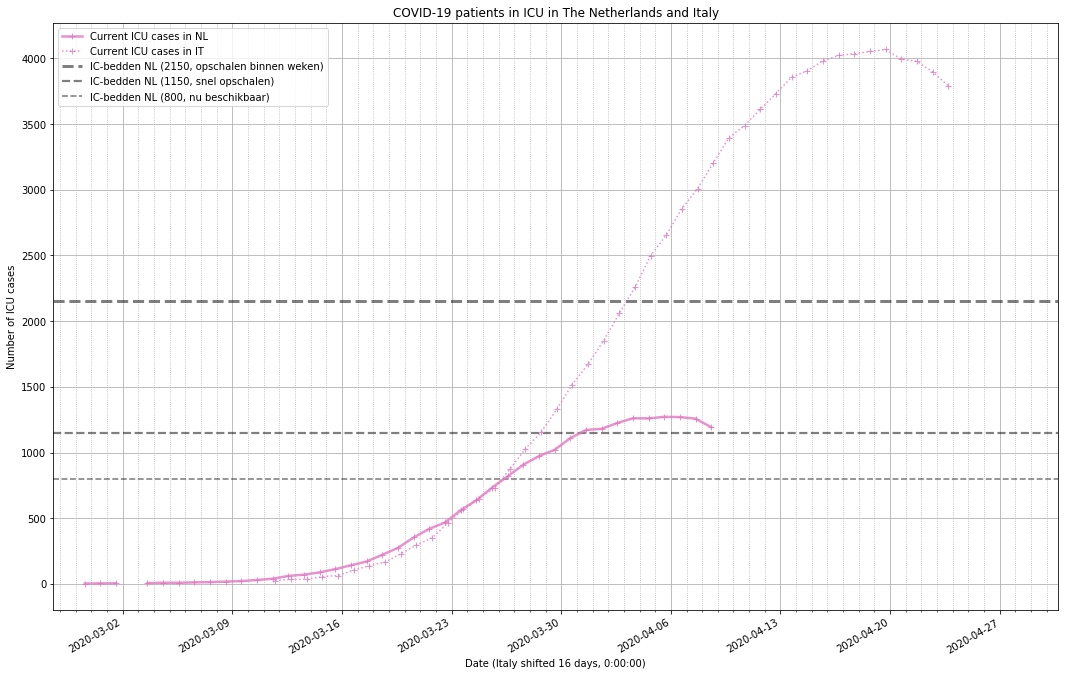

In [11]:
def plot_icu(ax, df, offset=None, country="", **kwargs):
    if offset:
        df = df.copy()
        df.index = df.index + offset

    kwargs = {"alpha": 0.8, **kwargs}

    df.current_icu.plot(
        label=f"Current ICU cases in {country}", marker="+", ax=ax, c="C6", **kwargs
    )


#     df.deaths.plot(label=f"Total deaths in {country}", marker="x", ax=ax, **kwargs)


# plt.style.reload_library()
# plt.style.use('seaborn-notebook')

fig, ax = plt.subplots(figsize=(18, 12))

offset_italy = timedelta(days=16)
min_date = np.min(
    [df_netherlands.index.min(), df_italy.index.min() + offset_italy]
) - timedelta(days=1)
max_date = np.max(
    [df_netherlands.index.max(), df_italy.index.max() + offset_italy]
) + timedelta(days=7)

plot_icu(ax, df_netherlands, country="NL", lw=2.5)
plot_icu(ax, df_italy, offset=offset_italy, country="IT", style=":")

ax.hlines(
    2500 - 350,
    min_date,
    max_date,
    label="IC-bedden NL (2150, opschalen binnen weken)",
    lw=3,
    alpha=0.5,
    linestyle="--",
)
ax.hlines(
    1500 - 350,
    min_date,
    max_date,
    label="IC-bedden NL (1150, snel opschalen)",
    lw=2.2,
    alpha=0.5,
    linestyle="--",
)
ax.hlines(
    1150 - 350,
    min_date,
    max_date,
    label="IC-bedden NL (800, nu beschikbaar)",
    lw=1.6,
    alpha=0.5,
    linestyle="--",
)


# ax.set_yscale("log")

# ax.set_ylim([1, 3e4])
ax.set_xlim(min_date, max_date)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(0))
ax.xaxis.set_minor_locator(mdates.DayLocator())

ax.grid(which="minor", linestyle=(":"))
ax.grid(which="major")
ax.set_xlabel(f"Date (Italy shifted {offset_italy})")
ax.set_ylabel("Number of ICU cases")
ax.set_title("COVID-19 patients in ICU in The Netherlands and Italy")
fig.autofmt_xdate()

ax.legend(loc=2)

### Trend development

Visualisation of the trends in total cases, ICU cases and deaths. We fit an exponential function on a floating window of 7 days.

(<Figure size 1872x576 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11b642820>)

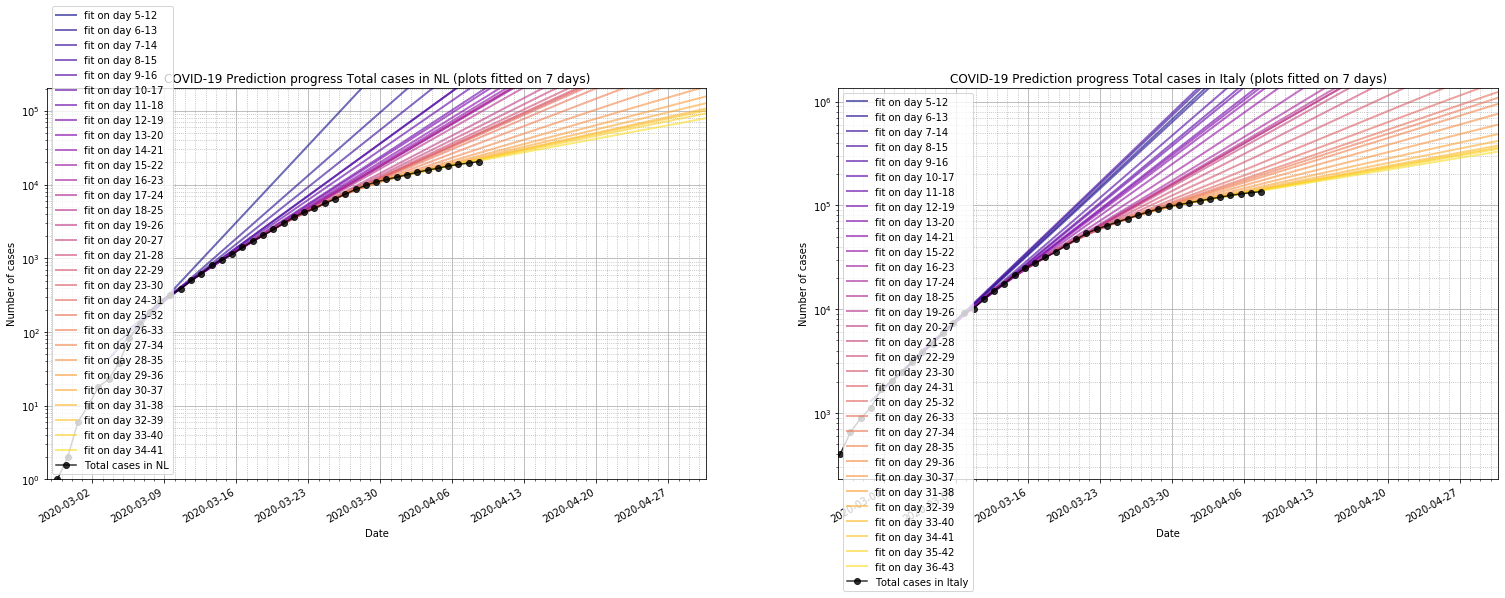

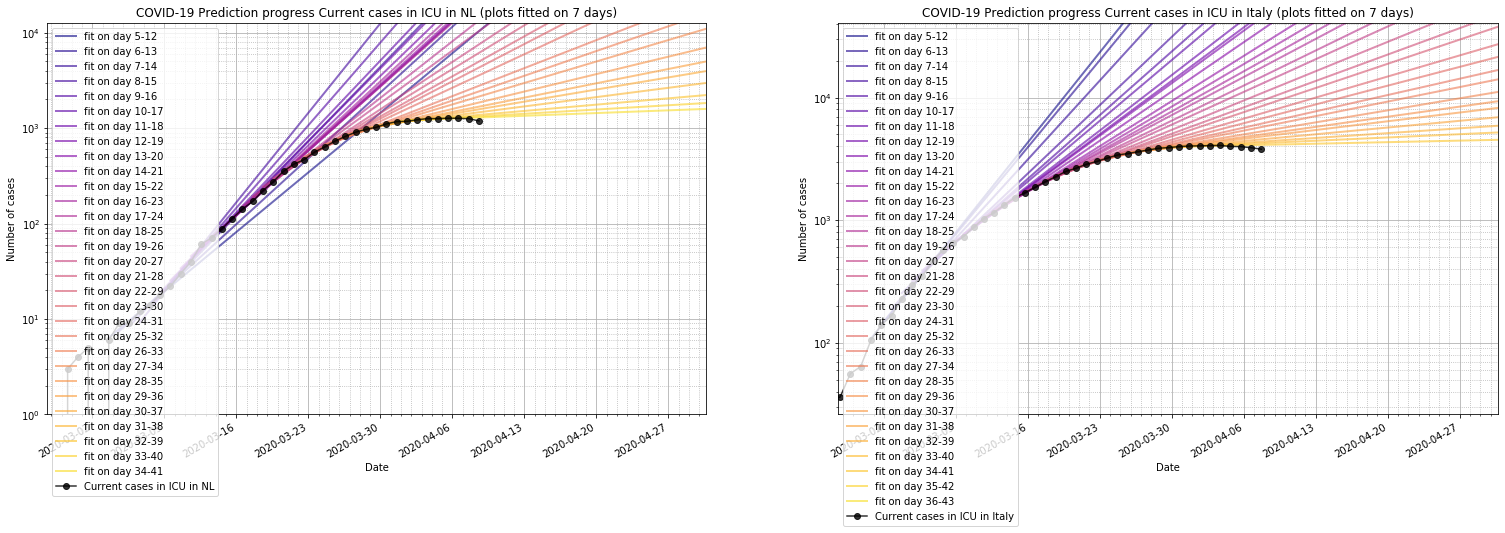

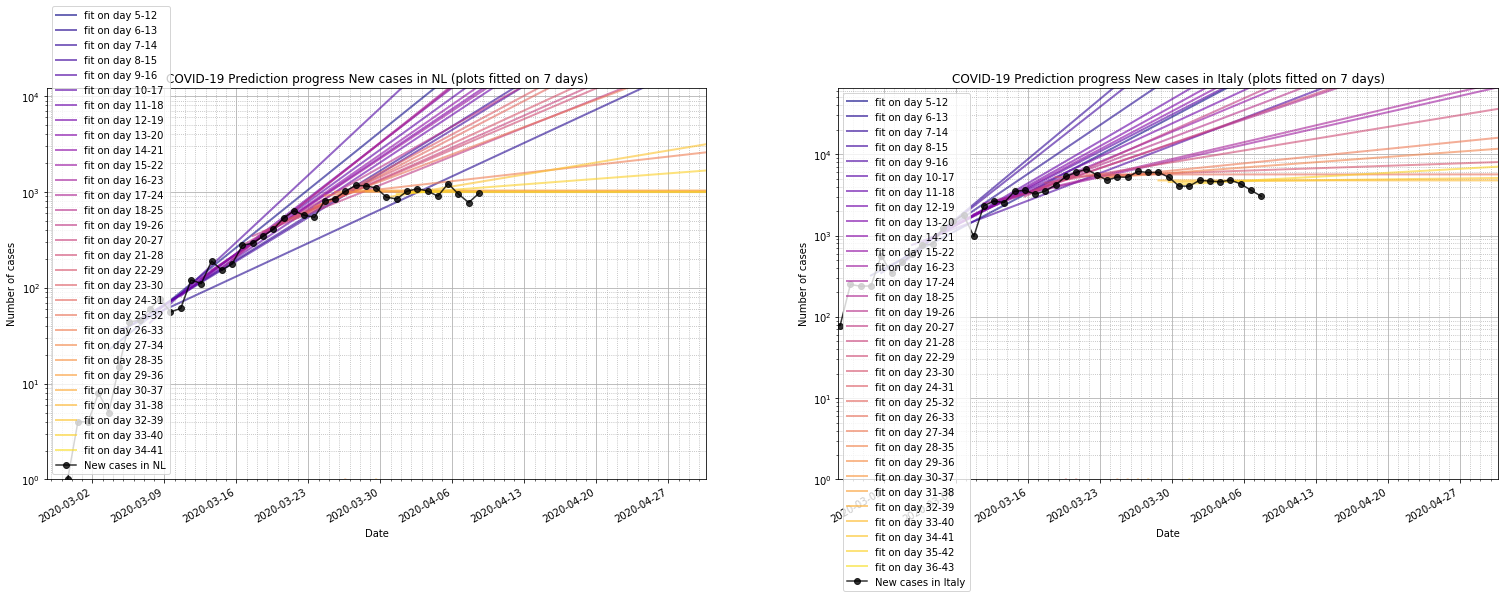

In [12]:
def fit_prediction(series, max_date, kind="exponential", offset=None):
    def exp_func(x, a, b):
        return b ** (x - a)

    def logistic_func(x, L, k, x0):
        return L / (1 + np.exp(-k * (x - x0)))

    try:
        [a, b], _ = curve_fit(
            exp_func,
            np.arange(len(series[:])),
            series[:].fillna(0),
            p0=[-30.0, 1.0],
            maxfev=10000,
        )
    except RuntimeError:
        [a, b] = np.array([0.0, 0.0])
    #     [L, k, x0], _ = curve_fit(
    #         logistic_func, np.arange(len(df.cumulative_cases)), df.cumulative_cases, p0=[1e4, 0.3, 30]
    #     )
    try:
        [k_, x0_], _ = curve_fit(
            lambda x, k_, x0_: logistic_func(x, 17.4e6, k_, x0_),
            np.arange(len(series)),
            series,
            p0=[0.3, 30],
            maxfev=10000,
        )
    except RuntimeError:
        [k_, x0_] = np.array([0.0, 0.0])

    date_index = pd.date_range(start=series.index.min(), end=max_date, freq="D",)
    y_pred_exp = exp_func(np.arange(len(date_index)), a, b)
    #     y_pred_logistic = logistic_func(np.arange(len(date_index)), L, k, x0)

    label = ""
    if kind == "exponential":
        curve = pd.Series(index=date_index, data=y_pred_exp)
        label = f"prediction: {b.round(3)}^x"
    elif kind == "logistic":
        curve = pd.Series(index=date_index, data=y_pred_logistic)
        label = f"Prediction: logistic function (conv. -> {L.round(1)})"
    else:
        raise Error(f"Unknown kind: {kind}")

    return curve, label


# plt.style.reload_library()
# plt.style.use('seaborn-notebook')


offset_italy = timedelta(days=16)
min_date = np.min(
    [df_netherlands.index.min(), df_italy.index.min() + offset_italy]
) - timedelta(days=1)
max_date = np.max(
    [df_netherlands.index.max(), df_italy.index.max() + offset_italy]
) + timedelta(days=7)

# for i in range(7, len(df_netherlands)):
#     curve, label = fit_prediction(df_netherlands[i-7:i], max_date=max_date)
#     curve.plot(ax=ax, c='C4', lw=1.6, alpha=.2+.3*i/len(df_netherlands))


def plot_trend_development(
    series, title, max_date, days=7, offset=None, skip_days=5, ax=None
):
    if not ax:
        fig, ax = plt.subplots(figsize=(15, 8))
    else:
        fig = ax.get_figure()

    series = series.copy()
    series = series.fillna(0)
    if offset:
        series.index = series.index + offset
    cmap = mpl.cm.get_cmap("plasma", len(series) + 2 - skip_days - days)

    for i in range(days + skip_days, len(series)):
        curve, label = fit_prediction(series[i - days : i], max_date=max_date)
        curve.plot(
            ax=ax,
            lw=2,
            alpha=0.6,
            c=cmap(i - days - skip_days),
            label=f"fit on day {i-days}-{i}",
        )

    series.plot(label=title, marker="o", c="k", ax=ax, alpha=0.8)

    ax.set_yscale("log")

    ax.set_ylim(np.max([series.min(), 1]), 10 * series.max())
    ax.set_xlim(min_date, max_date)

    ax.xaxis.set_major_locator(mdates.WeekdayLocator(0))
    ax.xaxis.set_minor_locator(mdates.DayLocator())

    ax.grid(which="minor", linestyle=(":"))
    ax.grid(which="major")
    ax.set_xlabel(f"Date")
    ax.set_ylabel("Number of cases")
    ax.set_title(f"COVID-19 Prediction progress {title} (plots fitted on {days} days)")
    fig.autofmt_xdate()
    ax.legend()
    return fig, ax


fig, axes = plt.subplots(1, 2, figsize=(26, 8))
plot_trend_development(
    df_netherlands.cumulative_cases, "Total cases in NL", max_date, ax=axes[0]
)
plot_trend_development(
    df_italy.cumulative_cases, "Total cases in Italy", max_date, ax=axes[1]
)

fig, axes = plt.subplots(1, 2, figsize=(26, 8))
plot_trend_development(df_netherlands.deaths, "Deaths in NL", max_date, ax=axes[0])
plot_trend_development(df_italy.deaths, "Deaths in Italy", max_date, ax=axes[1])

fig, axes = plt.subplots(1, 2, figsize=(26, 8))
plot_trend_development(
    df_netherlands.current_icu, "Current cases in ICU in NL", max_date, ax=axes[0]
)
plot_trend_development(
    df_italy.current_icu, "Current cases in ICU in Italy", max_date, ax=axes[1]
)

fig, axes = plt.subplots(1, 2, figsize=(26, 8))
plot_trend_development(
    df_netherlands.new_cases, "New cases in NL", max_date, ax=axes[0]
)
plot_trend_development(df_italy.new_cases, "New cases in Italy", max_date, ax=axes[1])

In [13]:
fig, ax = plt.subplots(figsize=(15, 8))


df_italy.performed_tests.plot(label="Performed tests", marker="x", ax=ax, alpha=0.8)

df_italy.cumulative_cases.plot(label="Cases", marker="o", ax=ax, alpha=0.8)

(100 * df_italy.cumulative_cases / df_italy.performed_tests).plot(
    label="Percentage positives", marker="o", ax=ax, alpha=0.8
)


ax.set_yscale("log")

# ax.set_ylim(1, 10*df_italy.performed_tests.max())
# ax.set_xlim(min_date, max_date)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(0))
ax.xaxis.set_minor_locator(mdates.DayLocator())

ax.grid(which="minor", linestyle=(":"))
ax.grid(which="major")
ax.set_xlabel(f"Date")
ax.set_ylabel("Number of cases")
ax.set_title(f"COVID-19 Performed tests and total cases in Italy")
fig.autofmt_xdate()
ax.legend()

In [ ]:
assert(not os.path.isfile('data/nl.csv'))
# Produce NL dataset as csv. Last updated: 21 march 2020

# fmt:off
besmettingen = np.array(
    [1, 2, 6, 10, 18, 23, 38, 82, 128, 188, 265, 321, 382, 503, 614, 804, 957,
     1135, 1413, 1705, 2051, 2460, 2994, 3631]
)
# fmt:on
schattingen = np.array([np.nan] * 17 + [6000])

sterfgevallen = np.array(
    [np.nan] * 8 + [1, 2, 4, 4, 4, 5, 5, 10, 12, 20, 24, 43, 58, 76, 106, 136]
)
ziekenhuisopnames = np.array(
    [np.nan] * 14 + [86, 115, 136, 162, 205, 314, 408, 489, 643, 836]
)

besmettingen = pd.Series(
    index=pd.date_range("2020-02-27", periods=len(besmettingen), freq="D"),
    data=besmettingen,
    name="besmettingen",
)
schattingen = pd.Series(
    index=pd.date_range("2020-02-27", periods=len(schattingen), freq="D"),
    data=schattingen,
    name="schatting",
)
ziekenhuisopnames = pd.Series(
    index=pd.date_range("2020-02-27", periods=len(ziekenhuisopnames), freq="D"),
    data=ziekenhuisopnames,
    name="schatting",
)
sterfgevallen = pd.Series(
    index=pd.date_range("2020-02-27", periods=len(sterfgevallen), freq="D"),
    data=sterfgevallen,
    name="sterfgevallen",
)

df_nl = pd.DataFrame({
    "cumulative_cases": besmettingen,
    "deaths": sterfgevallen,
    "hospitalized_cases": ziekenhuisopnames,
})
df_nl.index = df_nl.index + timedelta(hours=14)
df_nl.to_csv('data/nl.csv')

---
old

In [ ]:
# fmt:off
# italie_besmet = np.array(
#     [3, 3, 3, 3, 3, 4, 21, 79, 157, 229, 323, 470, 655, 889, 1128, 1701,
#      2036, 2502, 3089, 3858, 4636, 5883, 7375, 9172, 10149, 12462, 15113, 21157, 24747, 27980] + 20 * [np.nan]
# )
italie_besmet = np.concatenate([df_italy.total_cases.values, np.array(20 * [np.nan])])

# italie_sterf = np.array(
#     [np.nan] * 6 + [1, 2, 3, 7, 11, 12, 17, 21, 29, 41,
#      52, 79, 107, 148, 197, 233, 366, 463, 631, 827, 1016, 1441, 1809, 2158] + 20 * [np.nan]
# )
italie_sterf = np.concatenate([df_italy.deaths.values, np.array(20 * [np.nan])])



# italie_ziekenhuis = np.array(
# [np.nan] * 13 + [345, 401, 639, 742, 1034] + [np.nan]* 4 + [2651, 3557, 4316, 5038, 5838, 6650, 7426, 8372, 9663, 11025, 12894, 14363] + 20 * [np.nan]
# )
italie_ziekenhuis = np.concatenate([df_italy.hospitalized_without_icu.values, np.array(20 * [np.nan])])



# italie_ic = np.array(
#     [np.nan] * 13 + [64, 105, 140, 166, 229] + [np.nan]* 4 + [567, 650, 733, 877, 1028, 1153, 1328, 1518, 1672, 1851, 2060, 2257] + 20 * [np.nan]
# )
italie_ic = np.concatenate([df_italy.hospitalized_icu.values, np.array(20 * [np.nan])])




# fmt:on

italie_besmet = pd.Series(
    index=pd.date_range(df_italy.index.min(), periods=len(italie_besmet), freq="D"),
    data=italie_besmet,
)
italie_sterf = pd.Series(
    index=pd.date_range(df_italy.index.min(), periods=len(italie_sterf), freq="D"),
    data=italie_sterf,
)

italie_ziekenhuis = pd.Series(
    index=pd.date_range(df_italy.index.min(), periods=len(italie_ziekenhuis), freq="D"),
    data=italie_ziekenhuis,
)
italie_ic = pd.Series(
    index=pd.date_range(df_italy.index.min(), periods=len(italie_ic), freq="D"),
    data=italie_ic,
)

In [ ]:
df_italy.index + timedelta(days=16)

Functies en fits:

In [ ]:
def exp_func(x, a, b):
    return b ** (x - a)


def logistic_func(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))


[a, b], _ = curve_fit(exp_func, np.arange(len(besmettingen[:])), besmettingen[:])
[L, k, x0], _ = curve_fit(
    logistic_func, np.arange(len(besmettingen)), besmettingen, p0=[1e4, 0.3, 30]
)
[k_, x0_], _ = curve_fit(
    lambda x, k_, x0_: logistic_func(x, 17.4e6, k_, x0_),
    np.arange(len(besmettingen)),
    besmettingen,
    p0=[0.3, 30],
)


n_days = 70 + len(besmettingen)
date = pd.Series(
    index=pd.date_range("2020-02-27", periods=n_days, freq="D",),
    data=np.arange(n_days),
)

y_pred_exp = exp_func(date, a, b)
y_pred_logistic = logistic_func(date, L, k, x0)
y_pred_iedereen = logistic_func(date, 17.4e6, k_, x0_)

Plots:

In [ ]:
offset = 16

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(40, 28))

for ax_ in ax.flatten():
    besmettingen.plot(label="COVID-19-gevallen NL", marker="o", alpha=0.8, ax=ax_)
    schattingen.plot(marker="^", ax=ax_)
    y_pred_exp.plot(label=f"{b.round(3)}^x", alpha=0.8, style="--", ax=ax_)
    #     y_pred_logistic.plot(
    #         label=f"logistische functie (conv. -> {L.round(1)})", style=":", ax=ax_
    #     )
    #     y_pred_iedereen.plot(
    #         label=f"logistische functie (conv. -> 17.4e6", style=":", ax=ax_
    #     )
    ziekenhuisopnames.plot(label="ziekenhuisopnames NL", marker="+", alpha=0.8, ax=ax_)
    sterfgevallen.plot(label="Sterfgevallen NL", marker="x", alpha=0.8, ax=ax_)
    italie_besmet.shift(offset).plot(
        label=f"Besmettingen IT ({offset} d. offset)",
        marker="o",
        style=":",
        alpha=0.4,
        ax=ax_,
    )
    italie_sterf.shift(offset).plot(
        label=f"Sterfgevallen IT ({offset} d. offset)",
        marker="x",
        style=":",
        alpha=0.4,
        ax=ax_,
    )
    (italie_ic + italie_ziekenhuis).shift(offset).plot(
        label=f"Ziekenhuisopnames (inclusief IC) IT ({offset} d. offset)",
        marker="x",
        style="+",
        alpha=0.4,
        ax=ax_,
    )
    ax_.vlines(
        [pd.to_datetime("2020-03-01") + pd.to_timedelta(offset, "D")],
        -1e3,
        1e8,
        label=f"Maatregelen IT ({offset} d. offset)",
        linestyle="--",
        alpha=0.4,
    )
    ax_.vlines(
        ["2020-03-12"], -1e3, 1e8, label="Maatregelen NL", linestyle="--",
    )

for ax_ in ax[:, 0]:
    ax_.set_yscale("log")
ax[0, 0].set_ylim([0.6, 3e7])
ax[0, 0].hlines(17.4e6, date.index.min(), date.index.max(), label="inwoneraantal NL")


ax[1, 0].set_ylim([0.6, italie_besmet.max() * 2])
ax[1, 0].set_xlim("02-22-2020", besmettingen.index.max() + pd.to_timedelta(offset, "D"))
# ax[1, 0].legend(loc=2)


ax[0, 1].set_ylim([-10, L * 1.2])

ax[1, 1].set_xlim("02-26-2020", besmettingen.index.max() + pd.to_timedelta(offset, "D"))
ax[1, 1].set_ylim([-10, L * 1.2])

for ax_ in ax.flatten():
    ax_.legend()
    ax_.grid(which="minor", linestyle=(":"))
    ax_.grid(which="major")
    ax_.set_xlabel("datum")
    ax_.set_ylabel("Besmettingen NL")

plt.show()

R squared for the fits:

In [ ]:
pd.concat(
    [
        besmettingen.rename("actual numbers"),
        y_pred_logistic.rename("logistic"),
        y_pred_exp.rename("exponential fit"),
    ],
    axis=1,
).corr() ** 2

New cases:

In [ ]:
besmettingen.diff().plot()
plt.grid()
plt.show()

Ratio between new cases from day to day:

In [ ]:
(besmettingen.diff() / besmettingen.diff().shift()).plot()
plt.ylim([0.5, 2])
plt.grid()
plt.show()

In [ ]:
(besmettingen.diff() / besmettingen.diff().shift()).plot(marker="o")
(ziekenhuisopnames.diff() / ziekenhuisopnames.diff().shift()).plot(marker="+")
(sterfgevallen.diff() / sterfgevallen.diff().shift()).plot(marker="x")
plt.ylim([0, 3])
plt.xlim([None, besmettingen.index.max() + pd.to_timedelta(2, "d")])
plt.legend()
plt.grid()
plt.show()